In [1]:
import pandas as pd 
import pickle
import string
from pymongo import MongoClient 
from datetime import datetime,timedelta
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import logging
import pymagnitude
import sys
import numpy as np
import pandas_profiling
import datetime
import itertools
import logging
from scipy import stats
logger = logging.getLogger(__name__)

sys.path.insert(0, "//home//nlpsomnath//NegNews//zackc//Misc Notebooks//NN_VM//lib//python3.7//site-packages//negative_news//negative_news//util//")
from fines import get_data_from_article_title, transform_article_title, load_entity_dict, generate_report_string, max_marketshare
from desm import desm_pandas_wrapper

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager

from pyod.models.abod import ABOD
from pyod.models.knn import KNN

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

logger = logging.getLogger(__name__)
sent_tokenizer = nltk.tokenize.sent_tokenize
word_tokenizer = nltk.tokenize.word_tokenize

stopwords = stopwords.words('english')
newStopWords = ['.','?','%','&','Google','Wells Fargo','Donald Trump','Charles Schwab','Morgan Stanley','Credit Suisse','Reuters','Bank of America','Guggenheim','Deutsch Bank','Goldman Sachs','Facebook','Fifth Third Bank','New York','Washington','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday','January','February','March','April','May','June','July','August','September','October','November','December']
stopwords.extend(newStopWords)

#CONSTANTS
RESOURCES_PATH="/home/nlpsomnath/.local/lib/python3.5/site-packages/negative_news/resources/"
OUTPUT_PATH = "/home/nlpsomnath/NegNews/zackc/ContainerOutput/"

#one liner to fix issue with lazyconfig load 
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""


#FUNCTION TO EXTRACT MIC FOR MEASURING CORROLATION OF NON LINEAR RELATIONSHIPS ACROSS CONTINOUS SERIES
def get_MIC(x,y):
    import numpy as np
    from minepy import MINE
    mine = MINE(alpha=0.6, c=15, est="mic_approx")
    mine.compute_score(x, y)
    MIC = mine.mic()
    return MIC 

def normalize_pandas_series(series, _max=None, _min=None):
    if _max is None:
        if series.max() == 0:
            _max = 1
        else:
            _max = series.max()
    if _min is None:
        _min = series.min()
    return (series - _min) / (_max - _min)
             
def df_rowtypes(df,cols):
    df_copy = df.copy()
    df_copy.index = df.index
    df_copy.columns = df.columns

    #loop over indexes for each column and determine the type of data in each row of each column 
    #assignment to new dataframe based on idx location
    for col in cols:
        for i in df.index:
            val = type(df.loc[i, col]).__name__ 
            if val =='list':
                df_copy.loc[i, col] = len(df.loc[i, col])
            elif val =='dict':
                df_copy.loc[i, col] = len(df.loc[i, col].keys())
            else:
                df_copy.loc[i, col] = val
    return df_copy

def Desm_dict_to_df(row):
    
    #convert a dictonary of key : [(tup1_a,tup1_b),(tup2_a,tup2_b),.....] value pairs 
    #into a dataframe , where each column is representative of the column name in the resultign dataframe
    try:
        jobname = row['jobname']
        url = row['url']
        entity=row['entity']
        desm_dict = row['desm_score_dict']
        sents = row['sentence_tokenized_english']
    except KeyError as error:
        logger.error(print("Key {} Not found in Dictnary".format(error)))
        raise Exception("Key {} Not Found".format(error))
        
    #convert dictonary of tuples into a dataframe
    df = pd.DataFrame.from_dict(desm_dict,orient='columns')
    df_copy = df.copy()
    df_copy.index = df.index
    df_copy.columns = df.columns
    
    #reassign values back to a copy of original datafarme and return copied dataframe
    #removing the sentence index from each tuple, this information is retained in the index of the resulting dataframe
    #storing sent_index to ensure we retain correct order of sentences within each article
    sentindexs=[]
    for col in df.columns:
        for i in df.index:
            df_copy.loc[i, col] = df.loc[i, col][1]
            sentindexs.append(df.loc[i, col][0])
    df_copy['jobname']=jobname
    df_copy['url'] = url
    df_copy['entity']=entity
    df_copy['sentence']= pd.Series(sents)
    df_copy['sent_index'] = pd.Series(sentindexs)
    return df_copy

def numcols(df=None,numeric=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    cols = []
    for idx in df.index:
        for col in df.columns:
             if idx == df.index[0]:
                dype = type(df.loc[idx,col]).__name__
                
                if (numeric == True) & (dype in numerics):
                    #print('yes')
                    cols.append(col)
                if (numeric == False) & (dype not in numerics):
                    cols.append(col)
    return cols

def binVars_Longdf(df=None,var=None,var2replace=None,level=None,Thresholds=[-.05,.05,-.06]):
    df_copy = df.copy()
    df_copy.index = df.index
    df_copy.columns = df.columns

    for idx in df_copy.index:
        if df_copy.loc[idx,var]==level:
            sentval = df_copy.loc[idx,var2replace]

            if sentval < Thresholds[0]:
                df_copy.loc[idx,var2replace] = 0
            if sentval > Thresholds[1]:
                df_copy.loc[idx,var2replace] = 2
            if (sentval > Thresholds[2]) &(sentval <= Thresholds[1]):
                df_copy.loc[idx,var2replace] = 1
    return df_copy

#reset index of dataframe with categorical columns 
def Reset_index(df):
    '''Returns DataFrame with index as columns'''
    index_df = df.index.to_frame(index=False)
    df = df.reset_index(drop=True)
    #  In merge is important the order in which you pass the dataframes
    # if the index contains a Categorical. 
    # pd.merge(df, index_df, left_index=True, right_index=True) does not work
    return pd.merge(index_df, df, left_index=True, right_index=True)

import random
 
def colorsN(n):
    ret = []
    r = int(random.random() * 256)
    g = int(random.random() * 256)
    b = int(random.random() * 256)
    step = 256 / n
    for i in range(n):
        r += step
        g += step
        b += step
        r = int(r) % 256
        g = int(g) % 256
        b = int(b) % 256
        ret.append((r,g,b)) 
    return ret

def plotting_3d(x=None,y=None,z=None,color=None):
    # Import dependencies
    import plotly
    import plotly.graph_objs as go

    # Configure Plotly to be rendered inline in the notebook.
    plotly.offline.init_notebook_mode()

    # Configure the trace.
    trace = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker={
            'color':color,
            'colorscale':'Viridis',
            'size': 10,
            'opacity': 0.8,
        },

    )

    # Configure the layout.
    layout = go.Layout(
        margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
    )

    data = [trace]
    plot_figure = go.Figure(data=data, layout=layout)

    # Render the plot.
    plotly.offline.iplot(plot_figure)


In [3]:
###CONSTANTS FOR BELOW 
#z-score threshold to declare outlier
z_threshold = 3
#column to stratify on when identifying outliers 
stratifyOn = 'entity'
#columns to exclude when calculating outliers
cols2exclude = ['keep','year','date','knn_outlier','p_outlier','z_outlier','P_outlier','iqr_outlier']

In [48]:
##### Load Pickle of saved results
try:type(data)
except:
    data=pickle.load( open( "{}".format(OUTPUT_PATH)+"DF_With_DESM_Scores_AND_CLASSIFICATIONS.pickle", "rb" ) )
    data = pd.DataFrame(data)


#### Create datetime column and remove null dates
data['date'] = pd.to_datetime(data['date'],errors='coerce')
data = data[~data['date'].isnull()]
data['year'] = pd.DatetimeIndex(data['date'],ambiguous='NAT').year.astype(int)
data['date'].value_counts(dropna=False)

#convert document term tupe scores into columns 
words = list(set([item for sublist in [[x[0] for x in data.term_tupes[i]] for i in data.index] for item in sublist]))
data[words] = pd.DataFrame(data['term_tupes'].tolist(),index = data.index)

#rename column tuple term columns based on first elementin the row of each column 
old_names = words
new_names = []
for i in data.index:
    if i == data.index[0]:
        for col in words:
            new_names.append(data[col][i][0])

#replace original term column name with correct one 
data.rename(columns=dict(zip(old_names, new_names)), inplace=True)

#reassign each row of each column associated with term tup to the second element of each tuple (the actual max corr for the tup in the doc)
for col in new_names: 
    data[col] = data[col].apply(lambda x: x[1])
    
#drop id 
#data.drop(columns = ['_id'], inplace=True)

#subset columns to columns associated with document level information 
DocData = data[['content','date','entity','jobname','scraper','source','summary','title','url','entity_count',
                'max_desm_score','desm_term','doc_sentiment','year','sanction','revoke','penalty','infridgement','escalation',
                'deficiencies','restitution','suspension','fined','violation','collude']]

entity_count      0.0
max_desm_score    0.0
doc_sentiment     0.0
sanction          0.0
revoke            0.0
penalty           0.0
infridgement      0.0
escalation        0.0
deficiencies      0.0
restitution       0.0
suspension        0.0
fined             0.0
violation         0.0
collude           0.0
dtype: float64


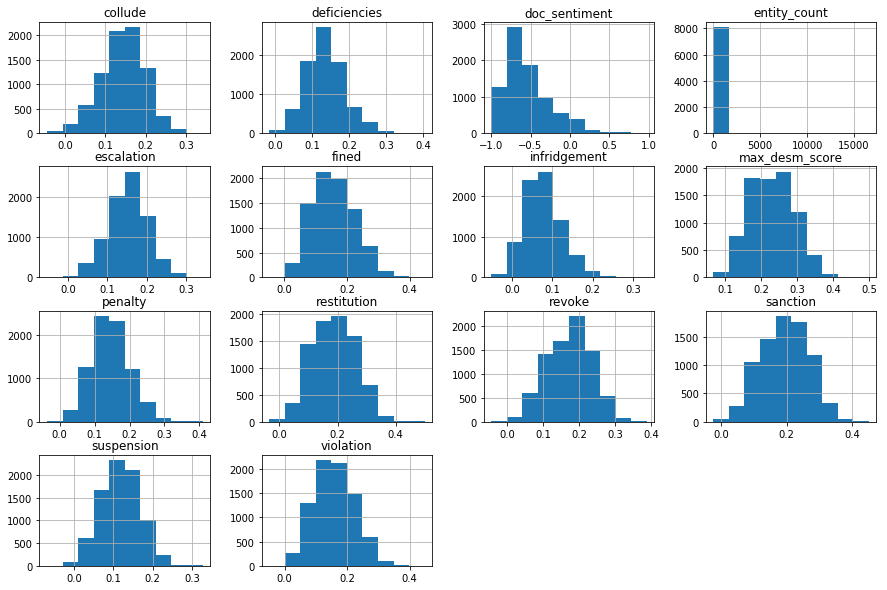

In [54]:
#visualize initital distributions of each series
cols = [col for col in DocData.columns if col not in cols2exclude]   
numcols = DocData[cols].describe().T.index
numcols = numcols
DocData[numcols].hist(figsize=(15,10))
print(DocData[numcols].isnull().sum()/len(df)*100)
        

##### Outlier based on >99% percentile

In [50]:
def PercentileOutliers(df = DocData,stratifyOn='entity', out_p = .99,cols2exclude = ['keep','year','date'],returnFull = False):
    #INPUTS 
    #df = input dataset 
    #stratifyOn = variable to split dataframe on when looking for outliers 
    #out_p = values gt the 99% percentile value for each column (by stratifyOn) that will be considered an outlier 
    #returnFull = if True, the entire Dataframe will be returned with a new column indicating outlier 
    
    #columns to include in outlier calculation 
    cols = [col for col in df.columns if col not in cols2exclude]   
    numcols = df[cols].describe().T.index
    numcols = numcols
    
    #create dictonary of 99% for each column stratified by entity 
    EntSummaryStats = {}
    for ent in df[stratifyOn].unique():
        entstats = df[df[stratifyOn]==ent].describe(percentiles = [out_p]).T
        pp = str(out_p)+'%'
        EntSummaryStats[ent] = entstats[str(int(out_p*100))+'%']
     
    #object to populate or manipulate based on outlier presence 
    DocData_NO = df.copy()
    Row_idxs = []
    Row_idxs_info = []
    
    #loop through each stratify group , and create list of all indexs across all groups that are outliers 
    for i,ent in enumerate(DocData_NO[stratifyOn].unique()):
        for key,value in EntSummaryStats[ent].items():
            Row_idxs.append((DocData_NO[(DocData_NO[stratifyOn]==ent) & (DocData_NO[key] > value)].index.values))
            Row_idxs_info.append((ent,DocData_NO.columns.get_loc(key),DocData_NO[(DocData_NO[stratifyOn]==ent) & (DocData_NO[key] > value)].index.values))
    
    #row indcies across all groups that need to be removed
    idxs2remove = list(set([item for sublist in Row_idxs for item in sublist]))
    
    #run if you only want the subset df with no outliers 
    if returnFull == False:
        DocData_NO.drop(idxs2remove, inplace=True)    
        print('Origal DF Shape:{}'.format(DocData.shape),'/n','Outlier Removed DF Shape: {}'.format(DocData_NO.shape))
    
    #run if you want the entire df with an outlier column flagging outliers 
    else: 
        DocData_NO['p_outlier'] = 0
        for idx in idxs2remove:
            DocData_NO.loc[idxs2remove, 'p_outlier'] = 1
        print('Total Outliers Flagged:{}'.format(DocData_NO[DocData_NO['p_outlier']==1].shape[0]))
    return(DocData_NO)

def out_std(s, nstd=3.0, return_thresholds=False):
    """
    Return a boolean mask of outliers for a series
    using standard deviation, works column-wise.
    param nstd:
        Set number of standard deviations from the mean
        to consider an outlier
    :type nstd: ``float``
    param return_thresholds:
        True returns the lower and upper bounds, good for plotting.
        False returns the masked array 
    :type return_thresholds: ``bool``
    """
    data_mean, data_std = s.mean(), s.std()
    cut_off = data_std * nstd
    lower, upper = data_mean - cut_off, data_mean + cut_off
    if return_thresholds:
        return lower, upper
    else:
        return [True if x < lower or x > upper else False for x in s]

DocData  = PercentileOutliers(df = DocData,stratifyOn='entity', out_p = .99,cols2exclude = ['keep','year','date'],returnFull = True)

Total Outliers Flagged:988


##### Outlier based on z-score > 3

In [51]:
##IDENTIFY AND REMOVE OUTLIERS 
#loop through each entity 
#calculate the z-score of each observation of each column 
#save row,col valuese for outliers 
#save DataFrame excluding outliers 
#save Dataframe with only outliers 
#concatenate non outlier dataframes for each entity into single df 
#concatenate outlier dataframes from each entity into single df
def ZScore_Outliers(df = DocData,stratifyOn='entity', z_threshold = 3,cols2exclude = ['keep','year','date'],returnFull = False):
    DocData_NO = df.copy()
    Row_idxs = []
    Row_idxs_info = []
 
    #columns to include in outlier calculation 
    cols = [col for col in df.columns if col not in cols2exclude]   
    numcols = df[cols].describe().T.index
    numcols = numcols

    #loop through each population stratified on
    #calculate z score 
    #identify z-scores > z_threshold and associated row INDEX 
    for i, ent in enumerate(df[stratifyOn].unique()):

        z = np.abs(stats.zscore(df[df[stratifyOn]==ent][numcols]))
        outs = np.where(z>z_threshold)
        
        #incies to remove
        Row_idxs.append([int(df.iloc[[row],[col]].index.values) for row,col in zip(outs[0],outs[1])])
        
        #informatin about indices to remove 
        Row_idxs_info.append([(ent,df[df[stratifyOn]==ent][numcols].iloc[[rowidx],[colidx]].columns[0],
                    float(df[df[stratifyOn]==ent][numcols].iloc[[rowidx],[colidx]].values),[rowidx,colidx])
                for rowidx,colidx in zip(outs[0],outs[1])])
                     
        
    #create list of row indcies to remove across all groups  
    idxs2remove = list(set([item for sublist in Row_idxs for item in sublist]))

     #run if you only want the subset df with no outliers 
    if returnFull == False:
        DocData_NO.drop(idxs2remove, inplace=True)    
        print('Origal DF Shape:{}'.format(DocData.shape),'/n','Outlier Removed DF Shape: {}'.format(DocData_NO.shape))

    #run if you want the entire df with an outlier column flagging outliers 
    else: 
        DocData_NO['z_outlier'] = 0
        for idx in idxs2remove:
            DocData_NO.loc[idxs2remove, 'z_outlier'] = 1
        print('Total Outliers Flagged:{}'.format(DocData_NO[DocData_NO['z_outlier']==1].shape[0]))
        
    return(DocData_NO)


DocData = ZScore_Outliers(df = DocData,stratifyOn='entity', z_threshold = 3,cols2exclude = ['keep','year','date'],returnFull = True)

Total Outliers Flagged:269


##### IQR Outlier Determination 

In [52]:
def IQR_Outliers(df = DocData,stratifyOn='entity',cols2exclude = ['keep','year','date'],returnFull = False):
    DocData_NO = df.copy()
    Row_idxs = []
    Row_idxs_info = []

    numcols = df.describe().T.index
    numcols = [col for col in numcols if col not in cols2exclude]

    for i, ent in enumerate(df[stratifyOn].unique()):

        df_sub =df[df[stratifyOn]==ent][numcols]
        Q1 = df_sub.quantile(0.25)
        Q3 = df_sub.quantile(0.75)
        IQR = Q3 - Q1
        
        #identify the index of the row/col combination associated with each outlier 
        Row_idxs.append(df_sub[~((df_sub < (Q1 - (1.5 * IQR))) |(df_sub > (Q3 + (1.5 * IQR)))).any(axis=1)].index.values)

    #create list of row indcies to remove across all groups  
    idxs2remove = list(set([item for sublist in Row_idxs for item in sublist]))

    if returnFull == False:
            DocData_NO.drop(idxs2remove, inplace=True)    
            print('Origal DF Shape:{}'.format(DocData.shape),'/n','Outlier Removed DF Shape: {}'.format(DocData_NO.shape))

        #run if you want the entire df with an outlier column flagging outliers 
    else: 
            DocData_NO['iqr_outlier'] = 0
            for idx in idxs2remove:
                DocData_NO.loc[idxs2remove, 'iqr_outlier'] = 1
            print('Total Outliers Flagged:{}'.format(DocData_NO[DocData_NO['iqr_outlier']==1].shape[0]))

    return(DocData_NO)

def out_iqr(s, k=1.5, return_thresholds=False):
    """
    Return a boolean mask of outliers for a series
    using interquartile range, works column-wise.
    param k:
        some cutoff to multiply by the iqr
    :type k: ``float``
    param return_thresholds:
        True returns the lower and upper bounds, good for plotting.
        False returns the masked array 
    :type return_thresholds: ``bool``
    """
    # calculate interquartile range
    q25, q75 = np.percentile(s, 25), np.percentile(s, 75)
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    if return_thresholds:
        return lower, upper
    else: # identify outliers
        return [True if x < lower or x > upper else False for x in s]

DocData = IQR_Outliers(df = DocData,stratifyOn='entity',cols2exclude = ['keep','year','date'],returnFull = True)

Total Outliers Flagged:6104


#### Multi-vairable outlier identification 

In [53]:
#PYDO KNN Outlier Detection 
#https://github.com/yzhao062/pyod
from pyod.models.knn import KNN   # kNN detector
from pyod.utils.data import evaluate_print
from pyod.utils.data import evaluate_print

def knn_outliers_MV(df =DocData,stratifyOn='entity',cols2exclude = ['keep','year','date','p_outlier,iqr_outlier,z_outlier'],returnFull=True ):
    DocData_NO = df.copy()
    Row_idxs = []
    Row_idxs_info = []

    numcols = DocData_NO.describe().T.index
    numcols = [col for col in numcols if col not in cols2exclude]

    for i, ent in enumerate(DocData_NO[stratifyOn].unique()):
        df_sub =DocData_NO[DocData_NO[stratifyOn]==ent][numcols]
        X_train=X_test = df_sub
        # train kNN detector
        clf_name = 'KNN'
        clf = KNN()
        clf.fit(X_train)

        # get the prediction label and outlier scores of the training data
        y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
        y_train_scores = clf.decision_scores_  # raw outlier scores

        # get the prediction on the test data
        y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
        y_test_scores = clf.decision_function(X_test)  # outlier scores
        df_sub['knn_outlier'] = y_test_pred

        #identify the index of the row/col combination associated with each outlier 
        Row_idxs.append(df_sub[df_sub['knn_outlier']==1].index.values)

    #create list of row indcies to remove across all groups  
    idxs2remove = list(set([item for sublist in Row_idxs for item in sublist]))

    if returnFull == False:
            DocData_NO.drop(idxs2remove, inplace=True)    
            print('Origal DF Shape:{}'.format(DocData_NO.shape),'/n','Outlier Removed DF Shape: {}'.format(DocData_NO.shape))

        #run if you want the entire df with an outlier column flagging outliers 
    else: 
            DocData_NO['knn_outlier'] = 0
            for idx in idxs2remove:
                DocData_NO.loc[idxs2remove, 'knn_outlier'] = 1
            print('Total Outliers Flagged:{}'.format(DocData_NO[DocData_NO['knn_outlier']==1].shape[0]))

    return(DocData_NO)

DocData = knn_outliers_MV(df =DocData,stratifyOn='entity',cols2exclude = ['keep','year','date','p_outlier,iqr_outlier,z_outlier'],returnFull=True )

entity_count      0.0
max_desm_score    0.0
doc_sentiment     0.0
sanction          0.0
revoke            0.0
penalty           0.0
infridgement      0.0
escalation        0.0
deficiencies      0.0
restitution       0.0
suspension        0.0
fined             0.0
violation         0.0
collude           0.0
p_outlier         0.0
z_outlier         0.0
iqr_outlier       0.0
dtype: float64
entity_count      0.0
max_desm_score    0.0
doc_sentiment     0.0
sanction          0.0
revoke            0.0
penalty           0.0
infridgement      0.0
escalation        0.0
deficiencies      0.0
restitution       0.0
suspension        0.0
fined             0.0
violation         0.0
collude           0.0
p_outlier         0.0
z_outlier         0.0
iqr_outlier       0.0
dtype: float64
entity_count      0.0
max_desm_score    0.0
doc_sentiment     0.0
sanction          0.0
revoke            0.0
penalty           0.0
infridgement      0.0
escalation        0.0
deficiencies      0.0
restitution       0.0
su

entity_count      0.0
max_desm_score    0.0
doc_sentiment     0.0
sanction          0.0
revoke            0.0
penalty           0.0
infridgement      0.0
escalation        0.0
deficiencies      0.0
restitution       0.0
suspension        0.0
fined             0.0
violation         0.0
collude           0.0
p_outlier         0.0
z_outlier         0.0
iqr_outlier       0.0
dtype: float64
entity_count      0.0
max_desm_score    0.0
doc_sentiment     0.0
sanction          0.0
revoke            0.0
penalty           0.0
infridgement      0.0
escalation        0.0
deficiencies      0.0
restitution       0.0
suspension        0.0
fined             0.0
violation         0.0
collude           0.0
p_outlier         0.0
z_outlier         0.0
iqr_outlier       0.0
dtype: float64
entity_count      0.0
max_desm_score    0.0
doc_sentiment     0.0
sanction          0.0
revoke            0.0
penalty           0.0
infridgement      0.0
escalation        0.0
deficiencies      0.0
restitution       0.0
su

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/usr

IndexError: index 8 is out of bounds for axis 0 with size 8

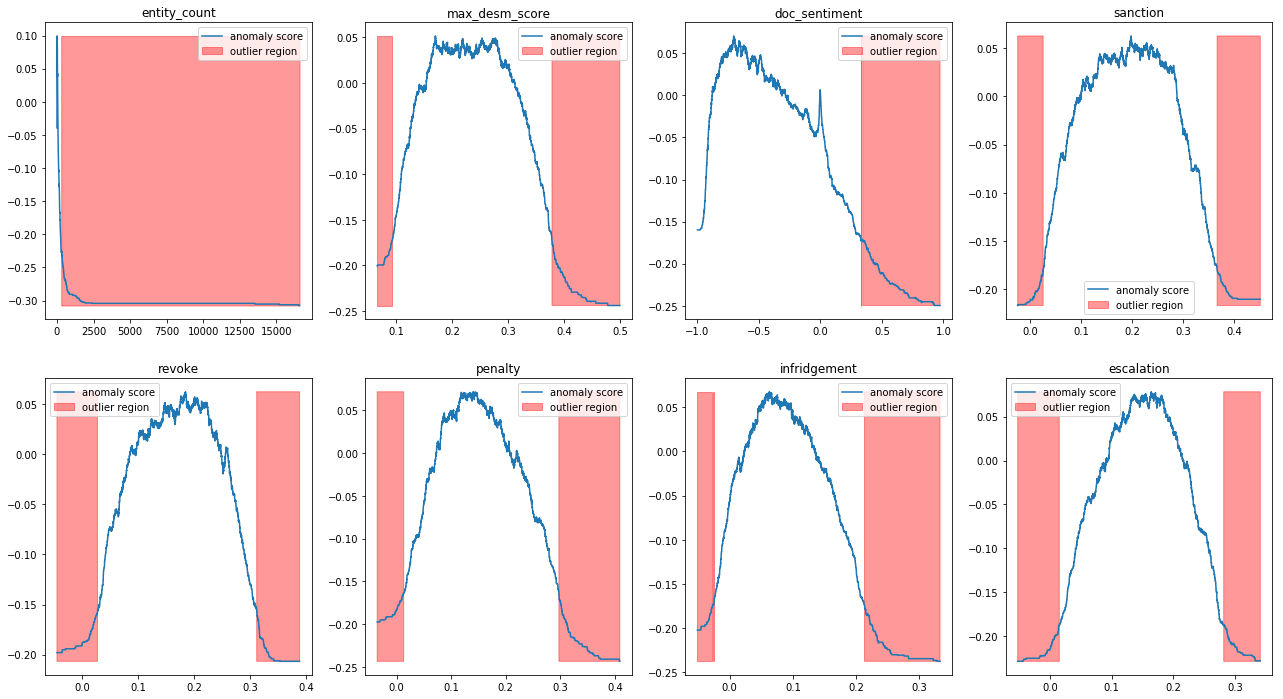

In [56]:
#ISOLATION FOREST 
#The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly 
#selecting a split value between the maximum and minimum values of the selected feature.

#Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate 
#a sample is equivalent to the path length from the root node to the terminating node.

#This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

#OUTLIER CRITERA:Random partitioning produces noticeable shorter paths for anomalies. Hence, when a forest of random trees collectively
#produce shorter path lengths for particular samples, they are highly likely to be anomalies.
#NOTE: isolation forest selects features at random and splits the data at random

from sklearn.ensemble import IsolationForest
fig, axs = plt.subplots(2, 4, figsize=(22, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()
ent = 'Wells Fargo'
for i, column in enumerate(numcols):
    isolation_forest = IsolationForest(contamination=.01)
    isolation_forest.fit(DocData[column].values.reshape(-1,1))

    xx = np.linspace(DocData[column].min(), DocData[column].max(), len(DocData)).reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx, anomaly_score, label='anomaly score')
    axs[i].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                     where=outlier==-1, color='r', 
                     alpha=.4, label='outlier region')
    axs[i].legend()
    axs[i].set_title(column)

In [61]:
#ISOLATION FOREST 
#The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly 
#selecting a split value between the maximum and minimum values of the selected feature.

#Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate 
#a sample is equivalent to the path length from the root node to the terminating node.

#This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

#OUTLIER CRITERA:Random partitioning produces noticeable shorter paths for anomalies. Hence, when a forest of random trees collectively
#produce shorter path lengths for particular samples, they are highly likely to be anomalies.
#NOTE: isolation forest selects features at random and splits the data at random
from sklearn.ensemble import IsolationForest
from collections import Counter

def isoforest_out(df =DocData,stratifyOn='entity',cols2exclude = ['keep','year','date','p_outlier,iqr_outlier,z_outlier','knn_outlier'],returnFull=True ):
    DocData_NO = df.copy()
    Row_idxs = []
    Row_idxs_info = []
    
    numcols = DocData_NO.describe().T.index
    numcols = [col for col in numcols if col not in cols2exclude]
    
    for i, ent in enumerate(DocData_NO[stratifyOn].unique()):
        df_sub =DocData_NO[DocData_NO[stratifyOn]==ent][numcols]
        X_train=X_test = df_sub
        
        clf = IsolationForest(n_jobs=6,n_estimators=500, max_samples=256, random_state=23)
        clf.fit(X_train)
        y_pred_train = clf.predict(X_train)
        df_sub['iso_outlier'] = y_pred_train
        print(ent,'/n ',Counter(y_pred_train))
        
        #identify the index of the row/col combination associated with each outlier 
        Row_idxs.append(df_sub[df_sub['iso_outlier']==-1].index.values)
        
    #create list of row indcies to remove across all groups  
    idxs2remove = list(set([item for sublist in Row_idxs for item in sublist]))

    if returnFull == False:
            DocData_NO.drop(idxs2remove, inplace=True)    
            print('Origal DF Shape:{}'.format(DocData_NO.shape),'/n','Outlier Removed DF Shape: {}'.format(DocData_NO.shape))

        #run if you want the entire df with an outlier column flagging outliers 
    else: 
            DocData_NO['iso_outlier'] = 0
            for idx in idxs2remove:
                DocData_NO.loc[idxs2remove, 'iso_outlier'] = 1
            print('Total Outliers Flagged:{}'.format(DocData_NO[DocData_NO['iso_outlier']==1].shape[0]))

    return(DocData_NO)

DocData = isoforest_out(df =DocData,stratifyOn='entity',cols2exclude = ['keep','year','date','p_outlier,iqr_outlier,z_outlier','knn_outlier'],returnFull=True )

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (256) is greater than the total number of samples (49). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Investacorp /n  Counter({1: 44, -1: 5})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Cetera /n  Counter({1: 280, -1: 31})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (256) is greater than the total number of samples (149). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Standard Chartered Bank /n  Counter({1: 134, -1: 15})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (256) is greater than the total number of samples (49). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


David Lubin /n  Counter({1: 44, -1: 5})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (256) is greater than the total number of samples (59). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Legg Mason Inc /n  Counter({1: 53, -1: 6})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Wells Fargo /n  Counter({1: 448, -1: 50})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (256) is greater than the total number of samples (152). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Jes Staley /n  Counter({1: 136, -1: 16})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


COR /n  Counter({1: 535, -1: 60})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (256) is greater than the total number of samples (232). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Cor /n  Counter({1: 208, -1: 24})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


JPMorgan Chase Bank /n  Counter({1: 285, -1: 32})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (256) is greater than the total number of samples (122). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


MUFG /n  Counter({1: 109, -1: 13})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (256) is greater than the total number of samples (129). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Wedbush Securities /n  Counter({1: 116, -1: 13})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (256) is greater than the total number of samples (192). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Lek /n  Counter({1: 172, -1: 20})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Wedbush /n  Counter({1: 289, -1: 32})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (256) is greater than the total number of samples (153). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Rabobank /n  Counter({1: 137, -1: 16})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Axos /n  Counter({1: 410, -1: 46})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Deutsche Bank /n  Counter({1: 483, -1: 54})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (256) is greater than the total number of samples (42). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


ProEquities /n  Counter({1: 37, -1: 5})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


UBS /n  Counter({1: 292, -1: 33})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (256) is greater than the total number of samples (242). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


UBS AG /n  Counter({1: 217, -1: 25})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (256) is greater than the total number of samples (162). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


J.P. Morgan Securities /n  Counter({1: 145, -1: 17})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (256) is greater than the total number of samples (233). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Standard Chartered /n  Counter({1: 209, -1: 24})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (256) is greater than the total number of samples (82). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Legg Mason /n  Counter({1: 73, -1: 9})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Barclays /n  Counter({1: 367, -1: 41})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (256) is greater than the total number of samples (79). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


LPL Financial /n  Counter({1: 71, -1: 8})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (256) is greater than the total number of samples (193). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Barclays PLC /n  Counter({1: 173, -1: 20})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (256) is greater than the total number of samples (236). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


LPL /n  Counter({1: 212, -1: 24})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


CFD /n  Counter({1: 294, -1: 33})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (256) is greater than the total number of samples (54). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Jes Stanley /n  Counter({1: 48, -1: 6})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (256) is greater than the total number of samples (251). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Brighthouse /n  Counter({1: 226, -1: 25})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Chase Bank /n  Counter({1: 425, -1: 48})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (256) is greater than the total number of samples (22). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Ddeutsche Bank /n  Counter({1: 19, -1: 3})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (256) is greater than the total number of samples (17). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Tradition Securities and Derivatives /n  Counter({1: 15, -1: 2})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (256) is greater than the total number of samples (60). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Lek Securities /n  Counter({1: 54, -1: 6})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (256) is greater than the total number of samples (53). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


COR Clearing /n  Counter({1: 47, -1: 6})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (256) is greater than the total number of samples (52). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Cor Clearing /n  Counter({1: 46, -1: 6})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (256) is greater than the total number of samples (81). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


TIAA /n  Counter({1: 73, -1: 8})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (256) is greater than the total number of samples (46). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


COR Securities /n  Counter({1: 41, -1: 5})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (256) is greater than the total number of samples (191). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Bank of America /n  Counter({1: 172, -1: 19})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (256) is greater than the total number of samples (55). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


CFD Investments /n  Counter({1: 49, -1: 6})


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:250: UserWarning: max_samples (256) is greater than the total number of samples (71). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Axos Financial /n  Counter({1: 64, -1: 7})
Total Outliers Flagged:824


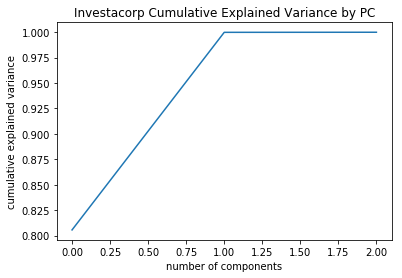

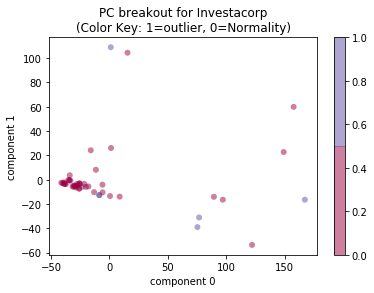

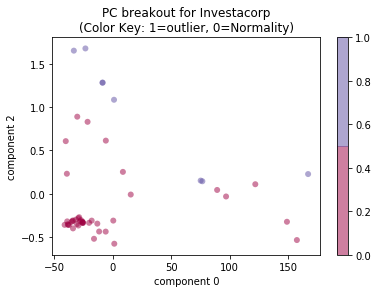

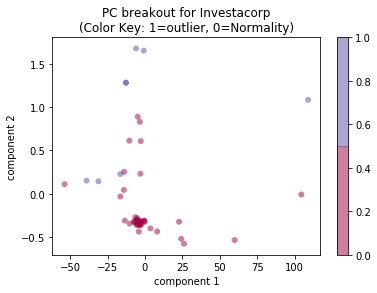

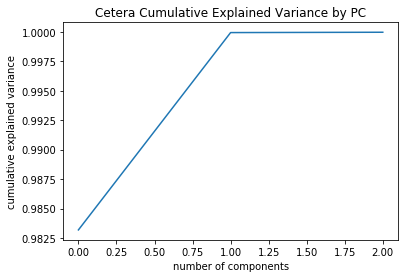

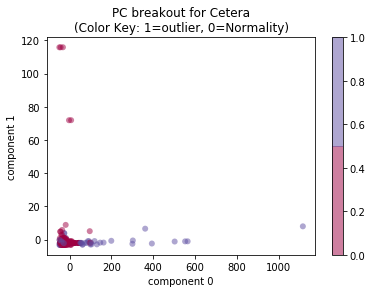

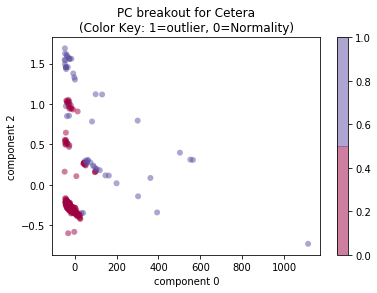

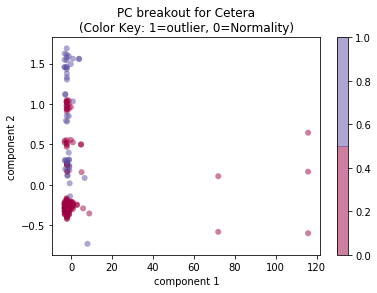

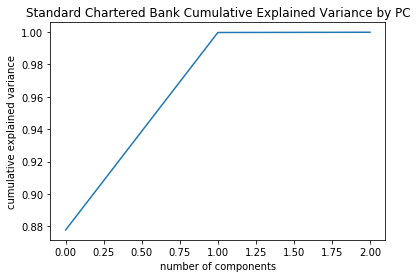

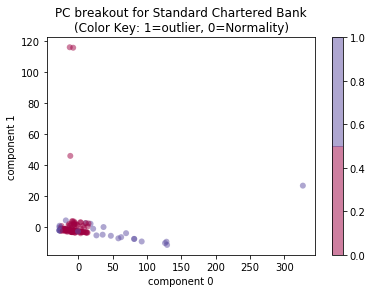

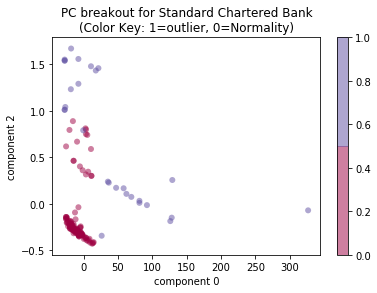

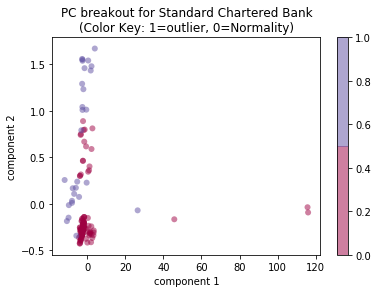

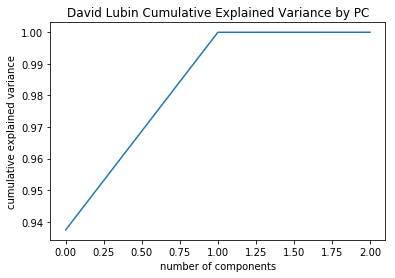

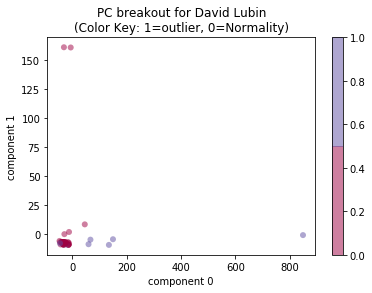

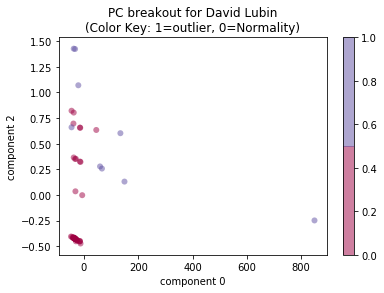

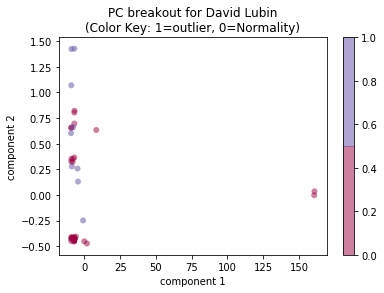

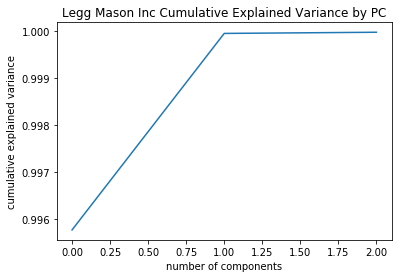

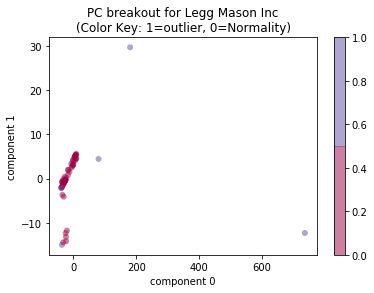

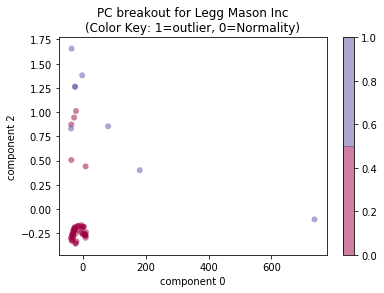

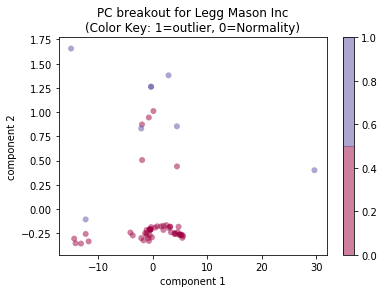

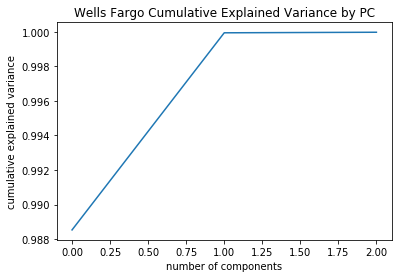

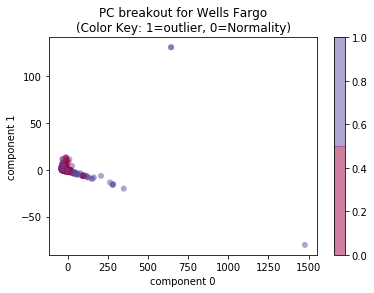

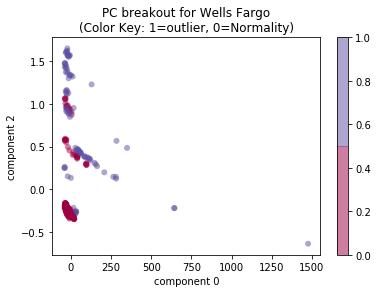

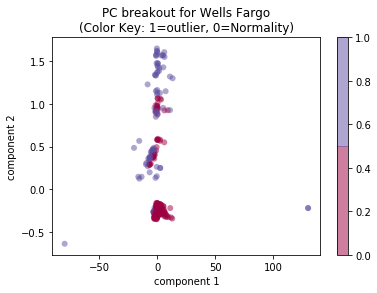

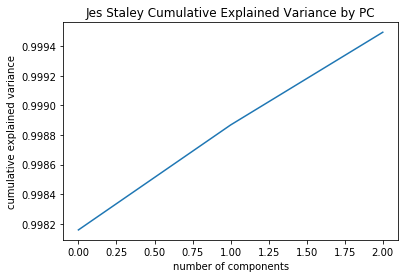

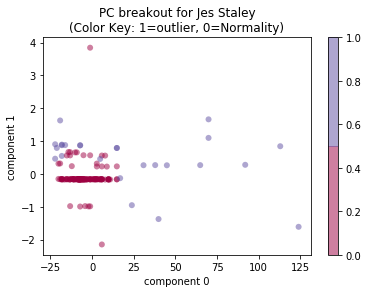

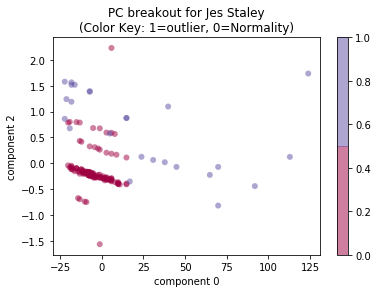

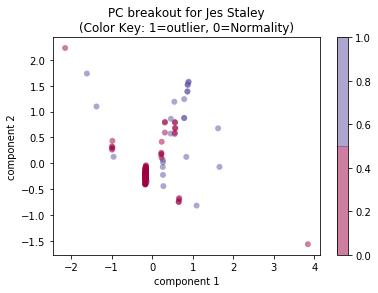

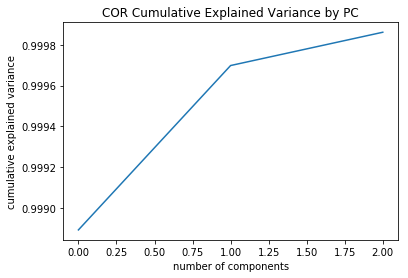

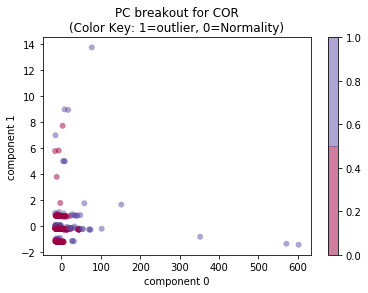

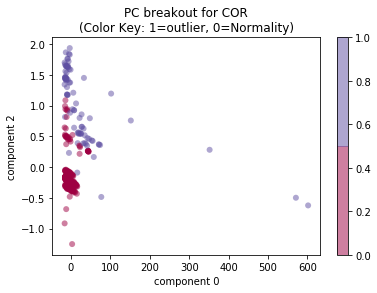

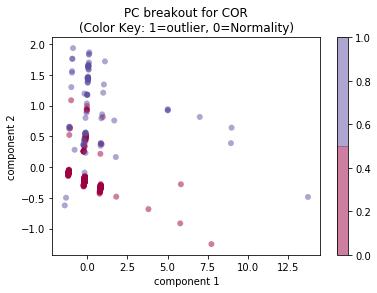

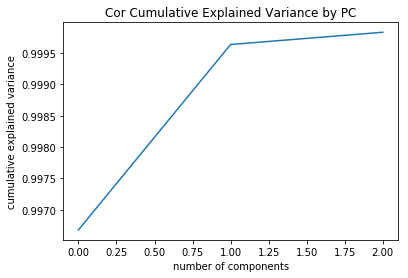

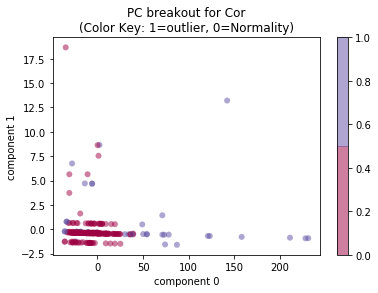

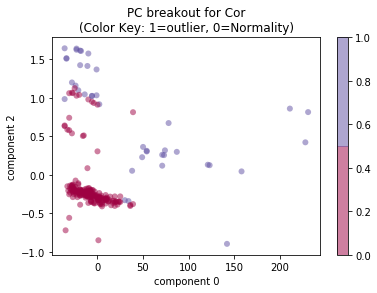

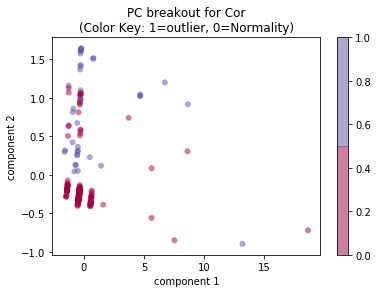

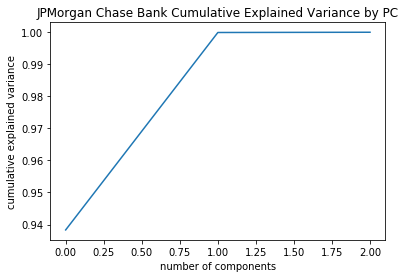

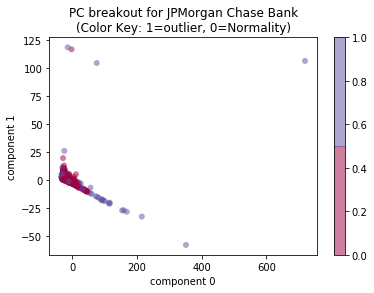

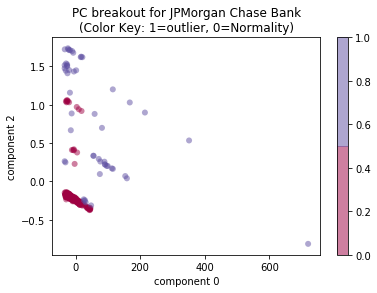

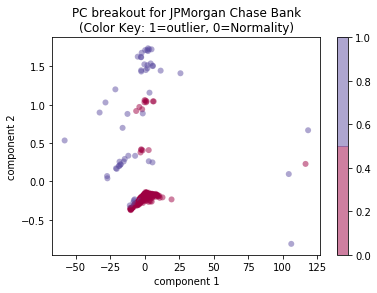

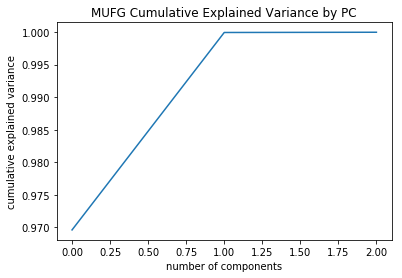

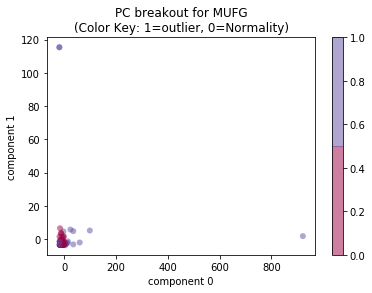

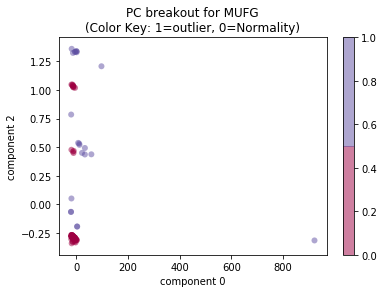

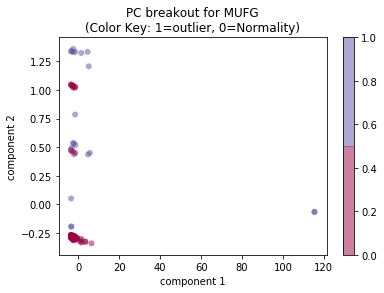

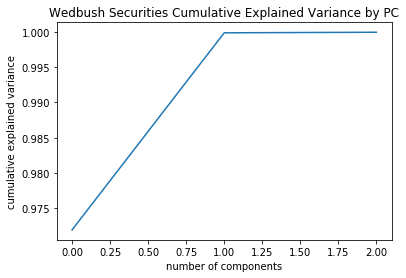

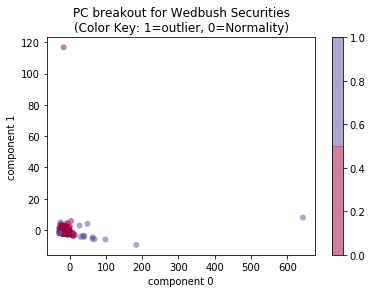

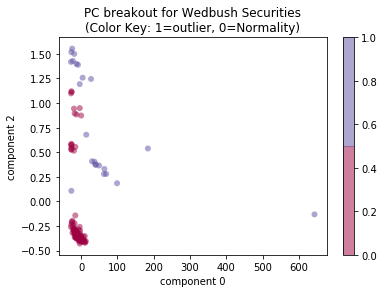

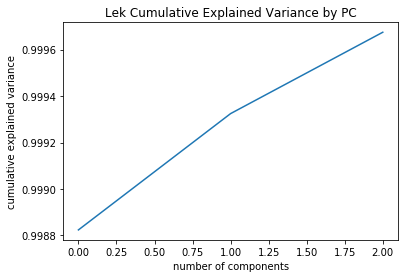

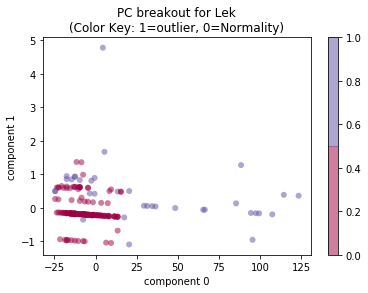

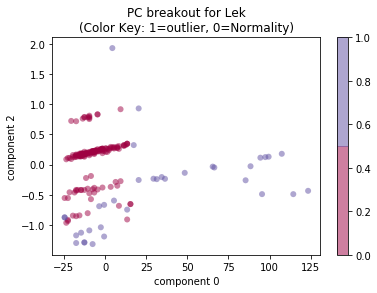

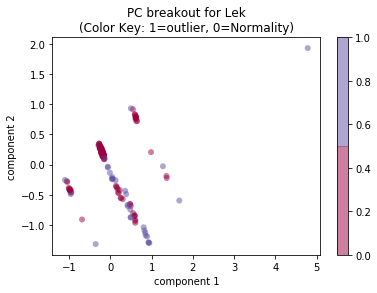

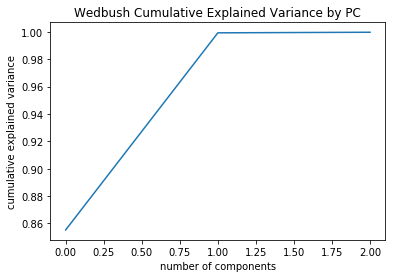

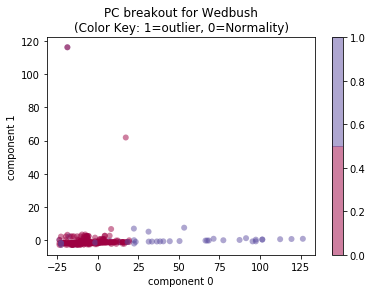

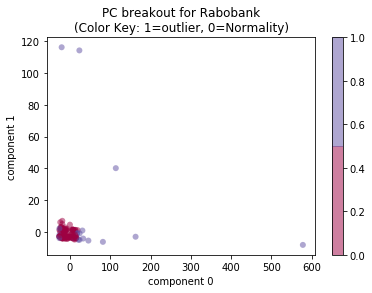

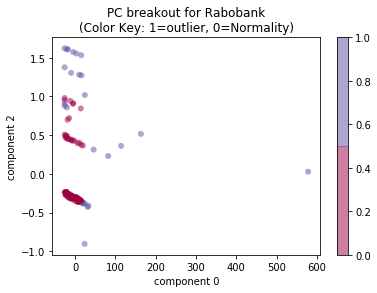

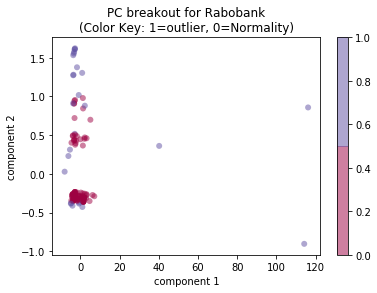

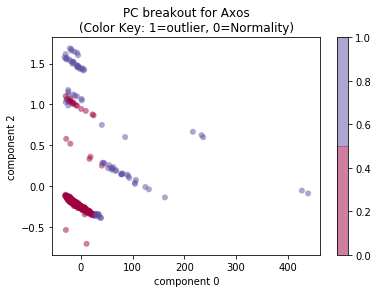

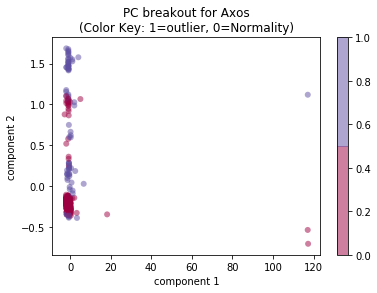

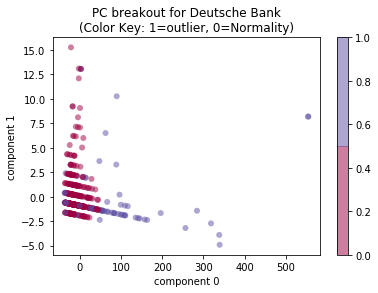

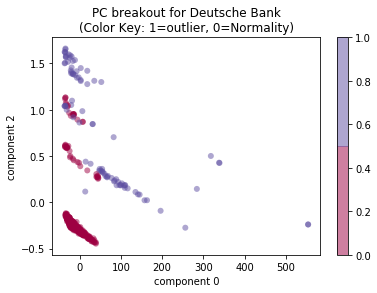

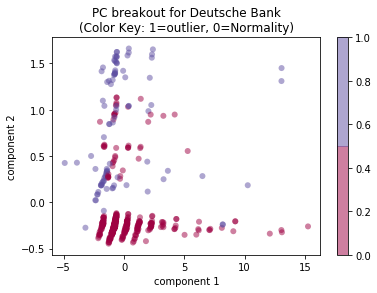

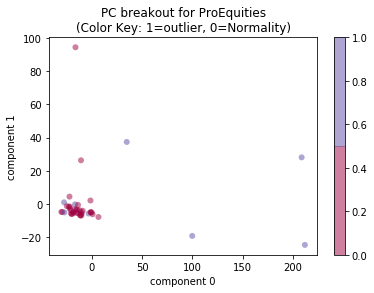

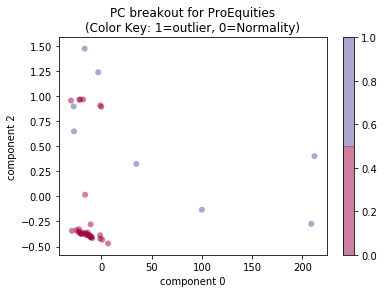

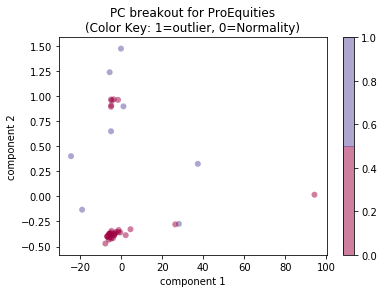

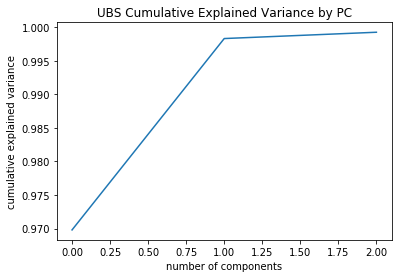

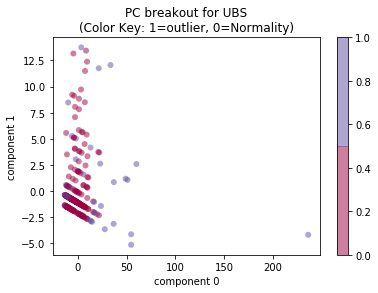

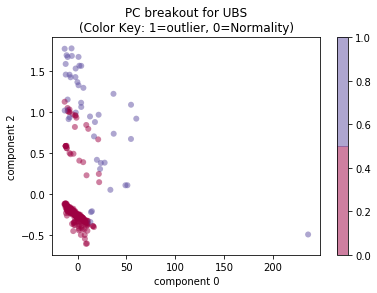

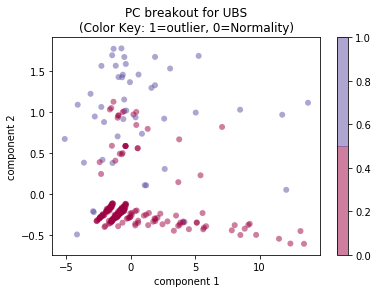

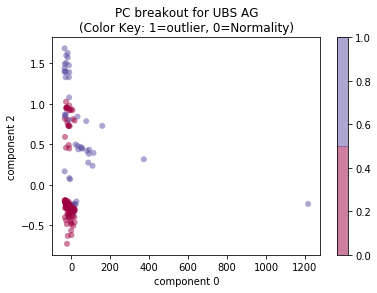

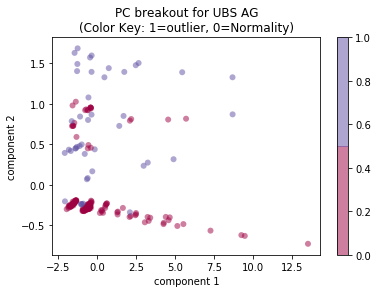

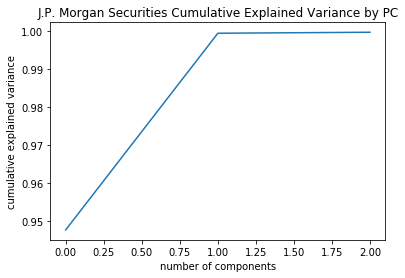

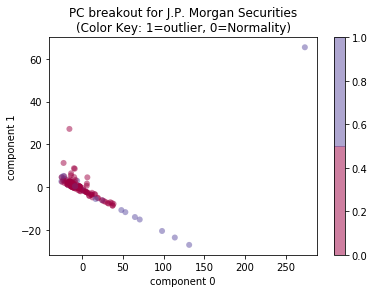

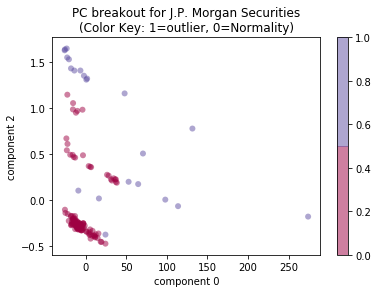

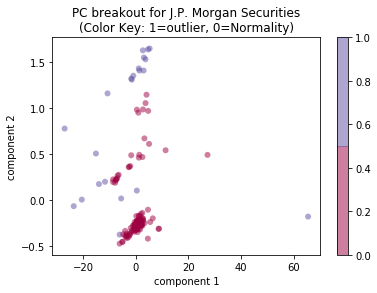

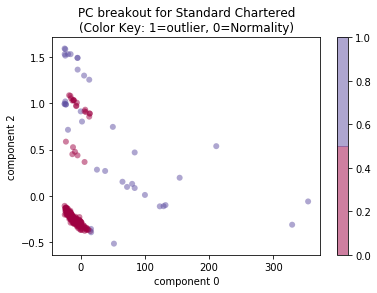

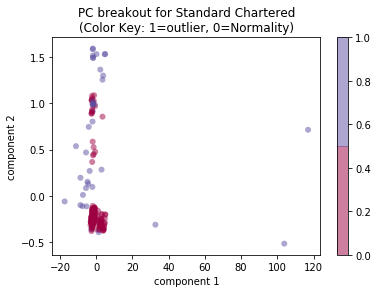

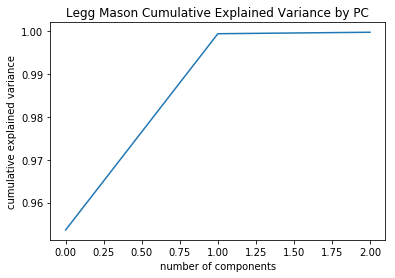

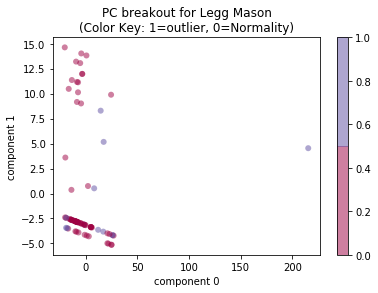

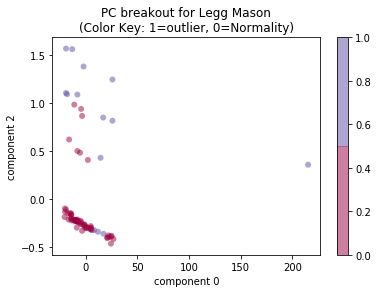

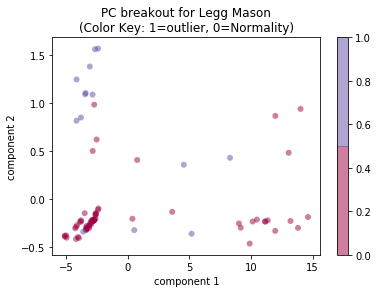

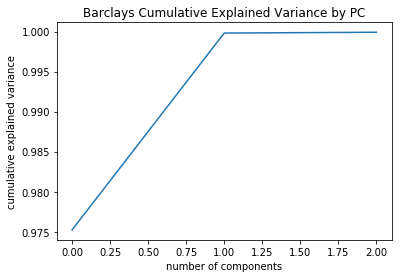

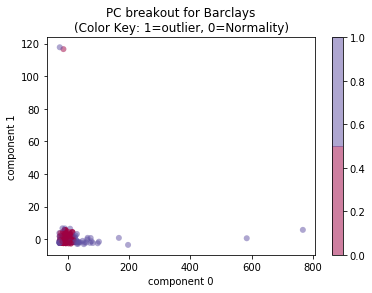

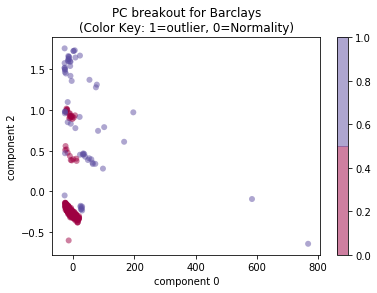

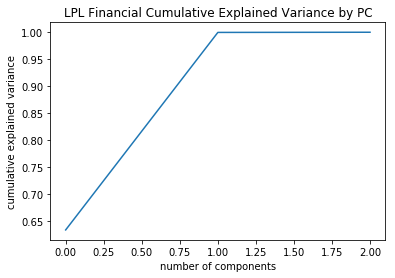

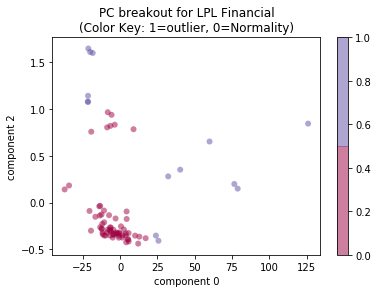

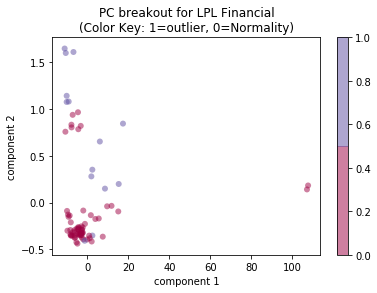

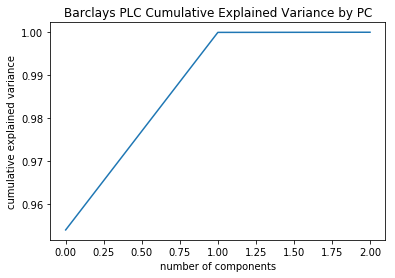

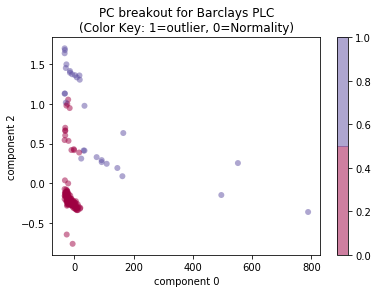

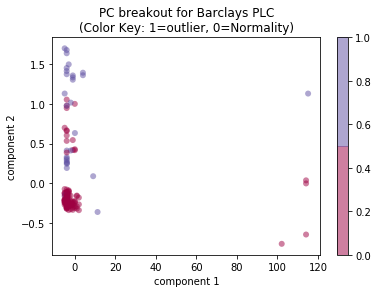

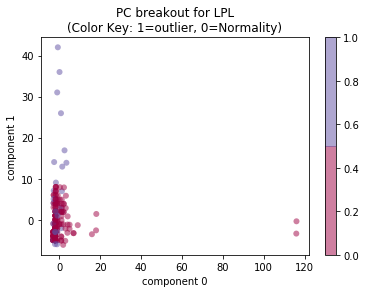

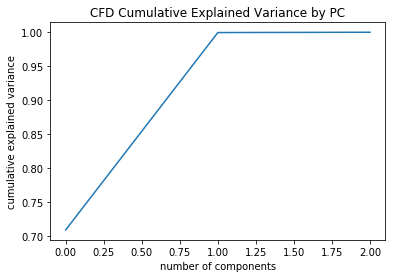

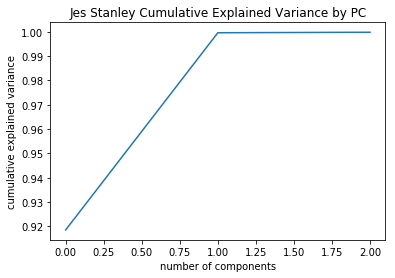

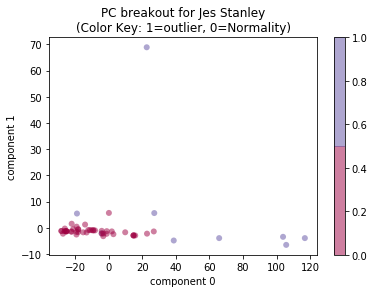

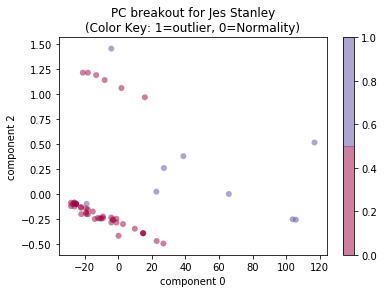

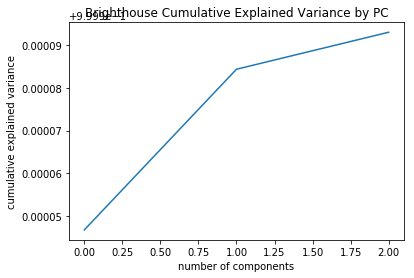

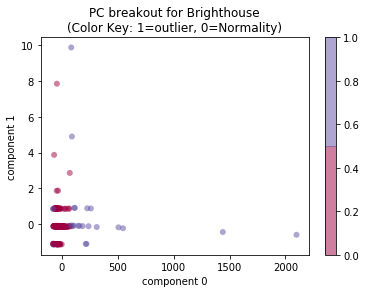

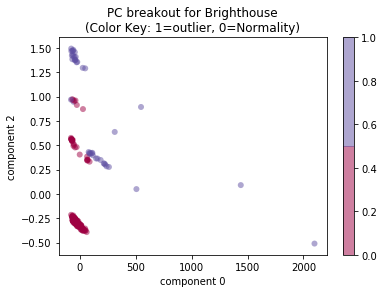

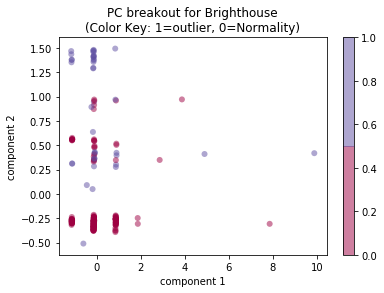

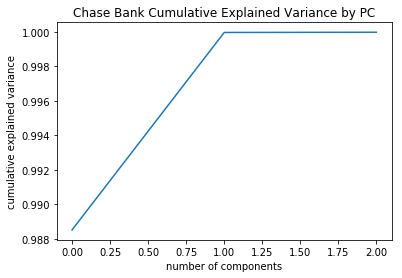

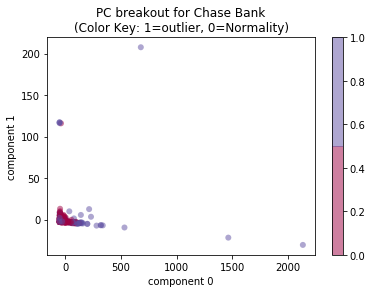

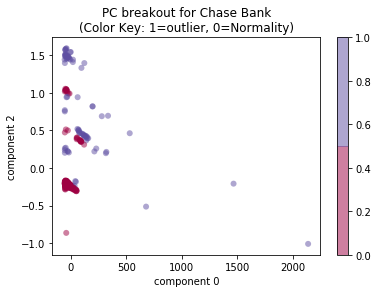

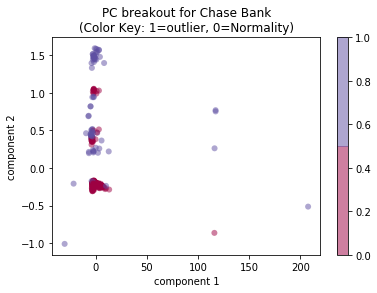

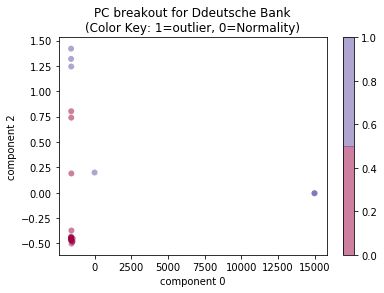

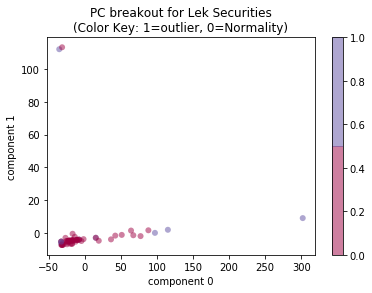

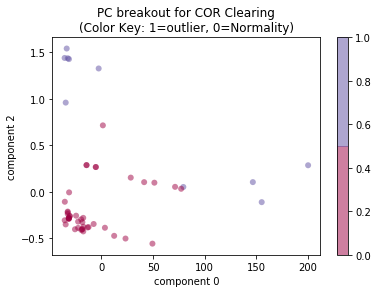

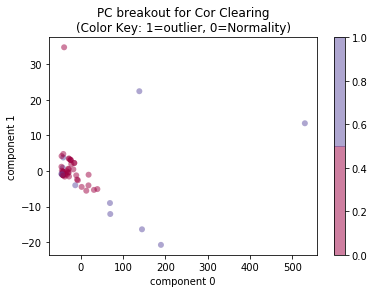

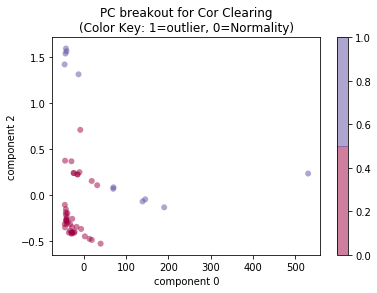

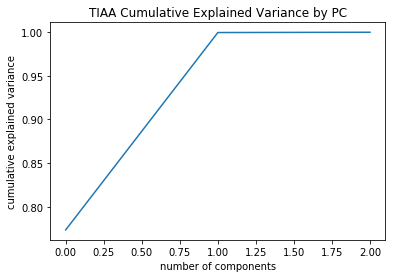

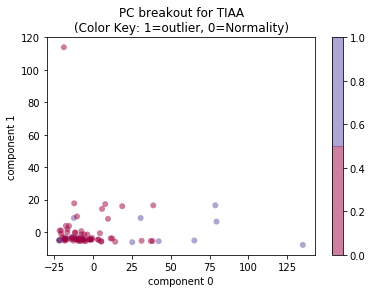

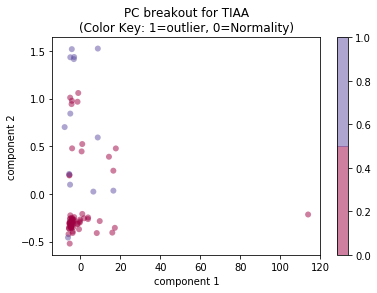

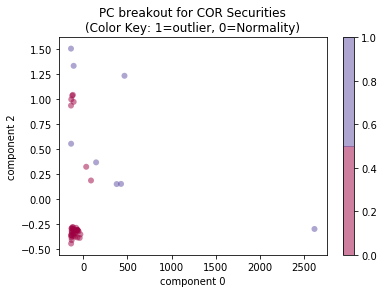

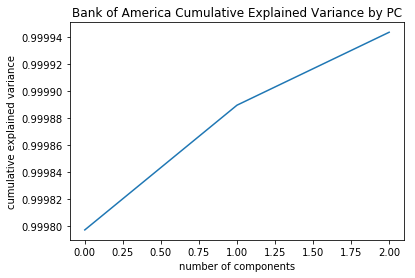

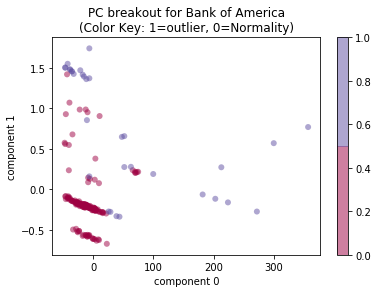

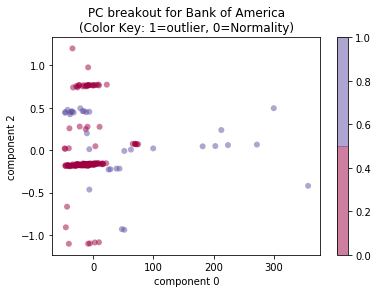

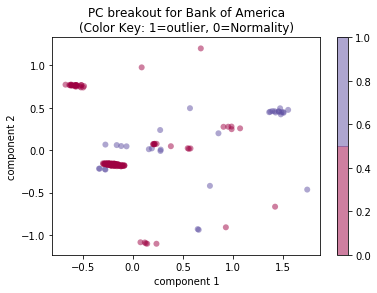

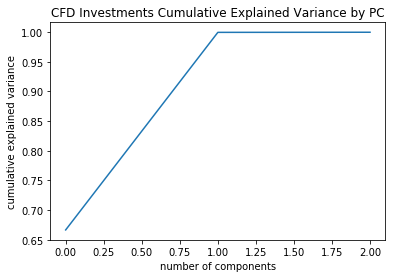

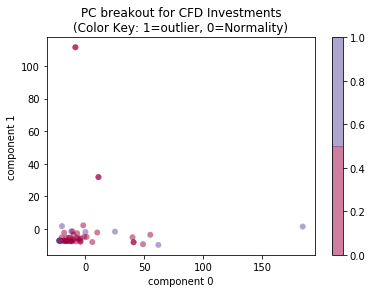

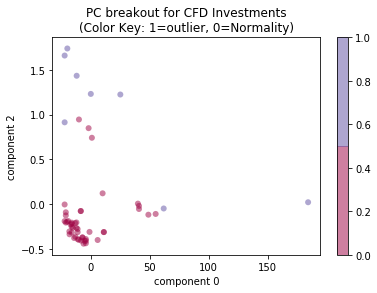

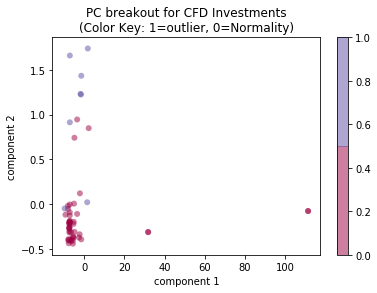

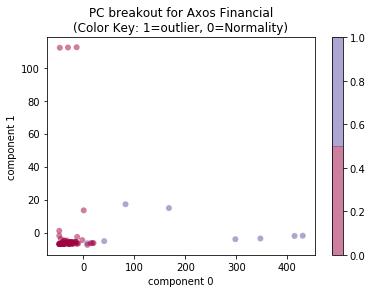

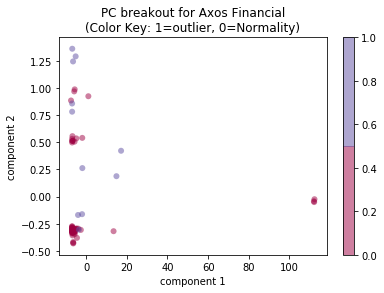

In [293]:
###EXPLORING OUTLIERS FROM ISOLATION FOREST THROUGH PCA 
import numpy as np 
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt
rng = np.random.RandomState(1)

pcs = 3
outlier2use = 'multiv_outlier'

for ent in DocData['entity'].unique(): 
    X =DocData[DocData['entity']==ent][numcols]#.to_numpy(copy=True)

    #fit pca
    pca=PCA(pcs)
    projected = pca.fit_transform(X)
    #pca = PCA().fit(X)

    #cumulative variance explained by PC 
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.title('{} Cumulative Explained Variance by PC'.format(ent))
    plt.xlabel('number of components');plt.ylabel('cumulative explained variance');plt.show()

    #join the pca projections to original data
    for i in range(0,len(projected.T)):
        var = 'pc{}'.format(i)
        X[var] =  projected[:,i]
    
    #create outliers columns 
    X['univ_outlier']=DocData[DocData['entity']==ent].apply(lambda x: min(1,x.p_outlier + x.z_outlier), axis=1)
    X['multiv_outlier']=DocData[DocData['entity']==ent].apply(lambda x: min(1,x.iso_outlier + x.knn_outlier), axis=1)

   
    #get list of all 2 way combinations of the PCs(store as tuples)
    combos = list(itertools.combinations([i for i in range(0,len(projected.T))], 2))
    
    #plot the principle components
    for one,two in combos:
        plt.scatter(projected[:, one], projected[:, two],
                         c=X[outlier2use], edgecolor='none', alpha=0.5,
                         cmap=plt.cm.get_cmap('Spectral', 2))

        plt.xlabel('component {}'.format(one))
        plt.ylabel('component {}'.format(two))
        plt.title('PC breakout for {}'.format(ent)+'\n'+'(Color Key: 1=outlier, 0=Normality)')
        plt.colorbar()
        plt.show()


#plotting_3d(x=projected[:, 0],y=projected[:, 1],z=projected[:, 2],color=X[outlier2use])

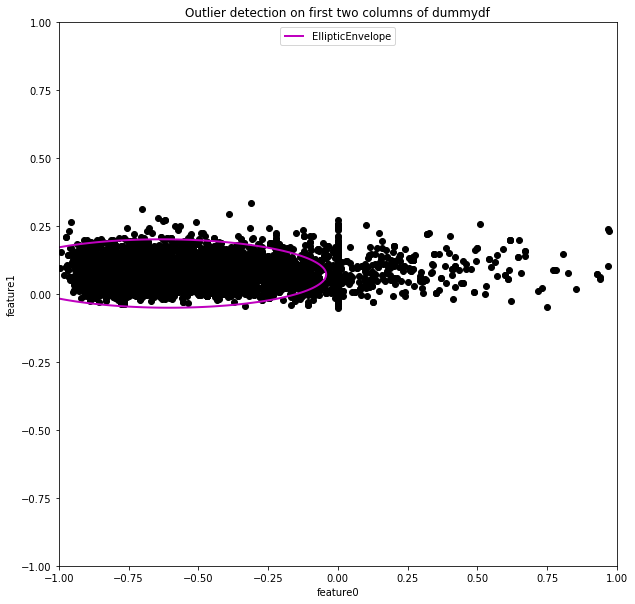

In [39]:
#MULTI-VARIANT OUTLIER DETECTION FOR NORMALLY DISTRIBUTED DATA
from sklearn.covariance import EllipticEnvelope
clf = EllipticEnvelope()

legend = {}
xx, yy = np.meshgrid(np.linspace(-1, 1, 500), np.linspace(-1, 1, 500))
plt.figure(1, figsize=(10,10))
clf.fit(DocData[numcols].values[:,[2,6]])
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
legend['EllipticEnvelope'] = plt.contour(
    xx, yy, Z, levels=[0], linewidths=2, colors=['m'])

legend_values_list = list(legend.values())
legend_keys_list = list(legend.keys())

plt.figure(1, figsize=(10,10))# two clusters
plt.title("Outlier detection on first two columns of dummydf")
plt.scatter(DocData[numcols].values[:, 2], DocData[numcols].values[:, 6], color='black')
bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")

plt.xlim((xx.min(), xx.max()))
plt.ylim((yy.min(), yy.max()))
plt.legend(legend_values_list[0].collections, legend_keys_list,
           loc="upper center");
plt.ylabel("feature1");
plt.xlabel("feature0");


In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
#NON PARAMETRIC OUTLIER DETECTION (FOR SKEWED DISTRIBUTIONS)
# scale data first
X = StandardScaler().fit_transform(DocData[numcols].values)

db = DBSCAN(eps=3.0, min_samples=10).fit(X)
labels = db.labels_
pd.Series(labels).value_counts()

plt.figure(figsize=(10,10))

unique_labels = set(labels)
colors = ['blue', 'red']

for color,label in zip(colors, unique_labels):
    sample_mask = [True if l == label else False for l in labels]
    plt.plot(X[:,0][sample_mask], X[:, 1][sample_mask], 'o', color=color);
plt.xlabel(label);
plt.ylabel('Standardized Price');

In [48]:
from sklearn.neighbors import LocalOutlierFactor
#LocalOutlierFactor
#I tried detecting outliers in the first two features again, but LocalOutlierFactor may require fine-tuning
#NOTE: YOU CAN USE MORE THAN 2 COLUMNS (>2 WORKS, just must adjust plotting)
clf = LocalOutlierFactor(n_neighbors=50, contamination='auto')
y_pred = clf.fit_predict(X[:,:2])

#plt.figure(figsize=(10,10))
# plot the level sets of the decision function
xx, yy = np.meshgrid(np.linspace(-3, 14, num=200), np.linspace(-3, 18, num=200))
Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

in_mask = [True if l == 1 else False for l in y_pred]
out_mask = [True if l == -1 else False for l in y_pred]

plt.title("Local Outlier Factor (LOF)")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
# inliers
a = plt.scatter(X[in_mask, 0], X[in_mask, 1], c='white',
                edgecolor='k', s=20)
# outliers
b = plt.scatter(X[out_mask, 0], X[out_mask, 1], c='red',
                edgecolor='k', s=20)
plt.axis('tight')
plt.xlabel('Standardized Number of Rooms');
plt.ylabel('Standardized Price');
plt.show()

[-1 -1 -1 ...  1  1  1]


ValueError: query data dimension must match training data dimension

In [55]:
DocData.head

content                    date                                entity                                            jobname         scraper                                   source                                            summary                                              title                                                url  entity_count  max_desm_score     desm_term  doc_sentiment  year  sanction    revoke   penalty  infridgement  escalation  deficiencies  restitution  suspension     fined  violation   collude  p_outlier  z_outlier  iqr_outlier  knn_outlier
6675  FINRA sanctioned six broker-dealers a combined... 1900-01-01 07:04:00.000                           Investacorp                      Investacorp_03-14-19-13-05-06   BingSearchAPI                             Stocklaw.com  Transamerica Financial Advisers was ordered to...  Voya, Transamerica, Investacorp, JP Turner, Na...  https://www.stocklaw.com/Securities-Fraud-Blog...             9        0.499053   restitution      -0.716367  1900  0.288705  0.252689  0.272018      0.087914    0.107387      0.149728     0.499053    0.237578  0.396669   0.255302  0.123951          1          1            0            0
2204  WASHINGTON — The Financial Industry Regulatory... 2015-10-20 00:00:00.000                                Cetera                           Cetera_03-14-19-11-11-01  BingRegulatory                   FINRA (Press Releases)                                                     FINRA Sanctions 12 Firms a Total of $6.7 Milli...  http://www.finra.org/newsroom/2015/finra-sanct...            34        0.477866   restitution      -0.563600  2015  0.278449  0.261612  0.206924      0.050110    0.154462      0.179915     0.477866    0.245276  0.440673   0.251210  0.122215          1          1            0            0
2935  In Standard Chartered Bank and Ors v. Director... 2015-03-14 00:00:00.000               Standard Chartered Bank          Standard Chartered Bank_03-14-19-11-11-01   BingSearchAPI                  Faciendum.wordpress.com  In Standard Chartered Bank and Ors v. Director...  Standard Chartered Bank and Ors v. Directorate...  https://faciendum.wordpress.com/2015/03/14/sta...            50        0.450959      sanction      -0.926467  2015  0.450959  0.291329  0.343351      0.010916    0.164559      0.169856     0.344858    0.229603  0.359308   0.380008  0.233231          1          1            0            1
3162  James M. Schneider was sentenced to seven year... 2019-02-15 00:00:00.000                           David Lubin                      David Lubin_03-14-19-11-11-01   BingSearchAPI                          Bizjournals.com  Schneider, a Boca Raton securities lawyer, was...  Boca lawyer gets prison time for pump-and-dump...  https://www.bizjournals.com/southflorida/news/...            17        0.448067   restitution      -0.854700  2019  0.257520  0.221528  0.242077      0.069907    0.136105      0.151327     0.448067    0.176574  0.318335   0.233014  0.189927          1          1            0            0
3081  It shall be unlawful for any person to enter t... 2019-03-14 00:00:00.000                                Cetera                           Cetera_03-14-19-11-11-01   BingSearchAPI                     Law.lis.virginia.gov  § 18.2-121. Entering property of another for p...  § 18.2-121. Entering property of another for p...  https://law.lis.virginia.gov/vacode/title18.2/...             4        0.447839     violation      -0.527733  2019  0.320055  0.268852  0.260323      0.072816    0.145674      0.165660     0.284864    0.213191  0.276515   0.447839  0.169333          1          1            0            0
6708  The Financial Industry Regulatory Authority (F... 2015-10-15 00:00:00.000                           Investacorp                      Investacorp_03-14-19-13-05-06   BingSearchAPI                   Whitesecuritieslaw.com  The other four firms fined by FINRA included I...                FINRA Fines 6 Firms Over REIT Sales  https://www